# Yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np 

prices = (yf.download(tickers="AAPL", 
                      start="2000-01-01", 
                      end="2022-12-31")
  .reset_index()
  .assign(symbol = "AAPL")
  .rename(columns = {"Date": "date", 
                     "Open": "open", 
                     "High": "high",
                     "Low": "low",
                     "Close": "close", 
                     "Adj Close": "adjusted", 
                     "Volume": "volume"
                    })
)
prices.head().round(3)

[*********************100%%**********************]  1 of 1 completed


,date,open,high,low,close,adjusted,volume,symbol
0,2000-01-03,0.936,1.004,0.908,0.999,0.847,535796800,AAPL
1,2000-01-04,0.967,0.988,0.903,0.915,0.776,512377600,AAPL
2,2000-01-05,0.926,0.987,0.920,0.929,0.787,778321600,AAPL
3,2000-01-06,0.948,0.955,0.848,0.848,0.719,767972800,AAPL
4,2000-01-07,0.862,0.902,0.853,0.888,0.753,460734400,AAPL


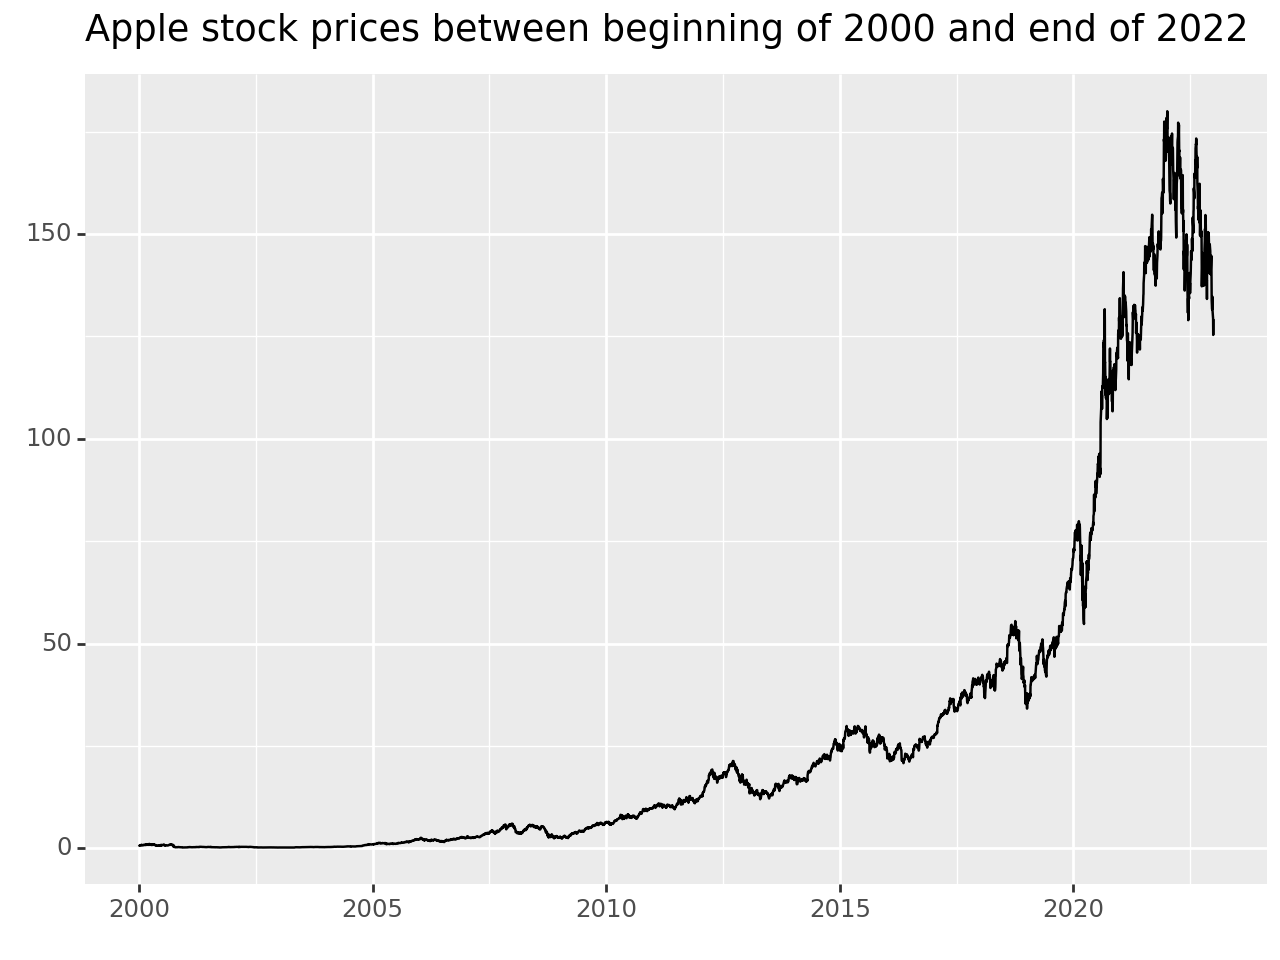

In [3]:
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

prices_figure = (
  ggplot(prices, 
         aes(y="adjusted", x="date")) +
 geom_line() +
 labs(x="", y="",
      title="Apple stock prices between beginning of 2000 and end of 2022") +
 scale_x_datetime(breaks=date_breaks("5 years"), 
                  labels=date_format("%Y"))
)
prices_figure.draw()

In [7]:
returns = (prices
  .sort_values("date")
  .assign(ret = lambda x: x["adjusted"].pct_change())
  .get(["symbol", "date", "ret"])
)
returns = returns.dropna() 
returns.head().round(3)

,symbol,date,ret
1,AAPL,2000-01-04,-0.084
2,AAPL,2000-01-05,0.015
3,AAPL,2000-01-06,-0.087
4,AAPL,2000-01-07,0.047
5,AAPL,2000-01-10,-0.018


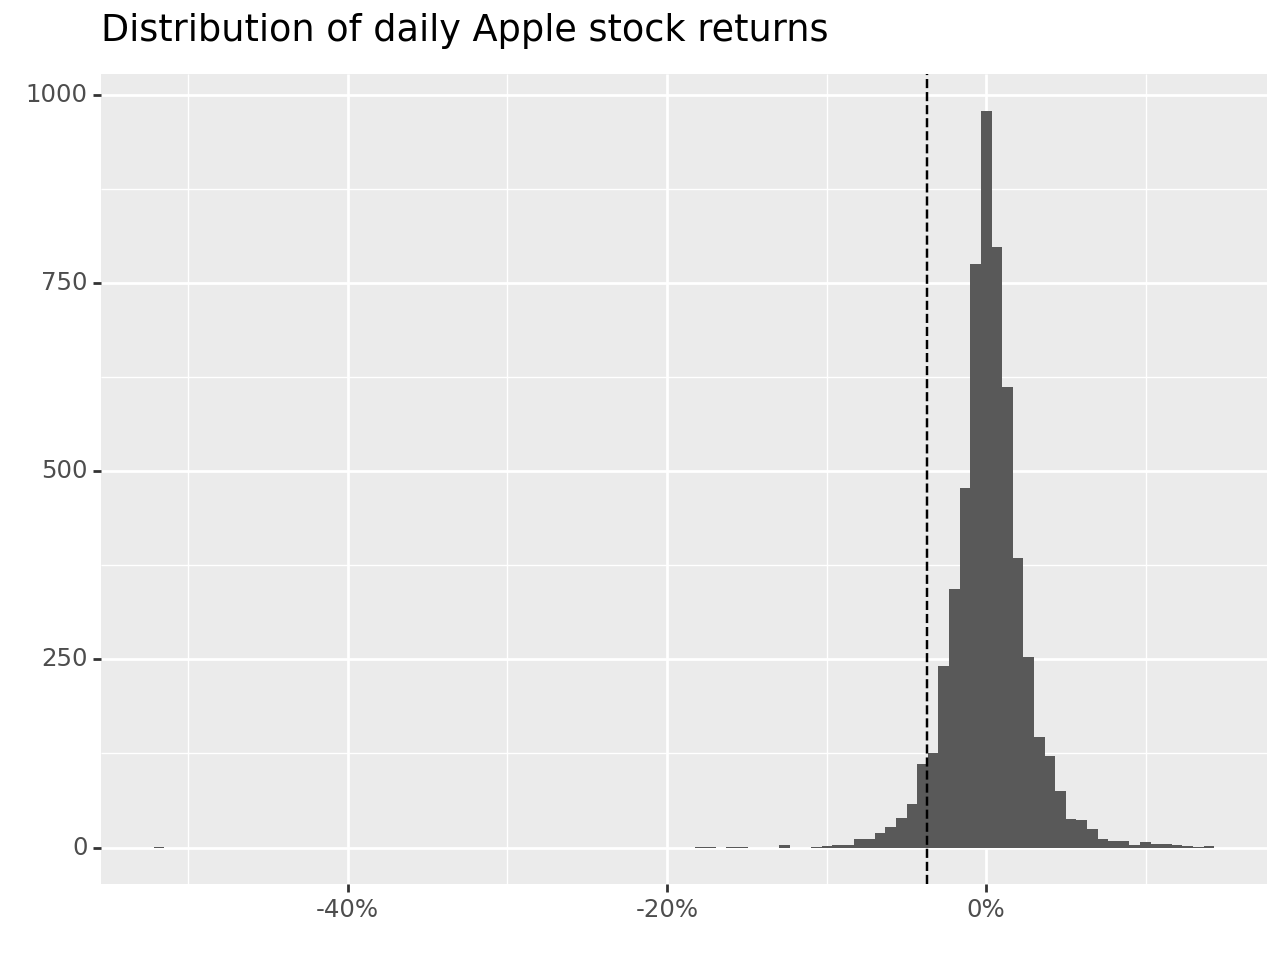

In [8]:
from mizani.formatters import percent_format

quantile_05 = returns["ret"].quantile(0.05)

returns_figure = (
  ggplot(returns, aes(x="ret")) +
  geom_histogram(bins=100) +
  geom_vline(aes(xintercept=quantile_05), 
                 linetype="dashed") +
  labs(x="", y="",
       title="Distribution of daily Apple stock returns") +
  scale_x_continuous(labels=percent_format())
)
returns_figure.draw()

In [10]:
returns["ret"].describe().round(3)

(returns["ret"]
  .groupby(returns["date"].dt.year)
  .describe()[["mean", "std", "min", "max"]]
  .round(3)
)

,mean,std,min,max
date,,,,
2000,-0.003,0.055,-0.519,0.137
2001,0.002,0.039,-0.172,0.129
2002,-0.001,0.031,-0.150,0.085
2003,0.002,0.023,-0.081,0.113
2004,0.005,0.025,-0.056,0.132
2005,0.003,0.024,-0.092,0.091
2006,0.001,0.024,-0.063,0.118
2007,0.004,0.024,-0.070,0.105
2008,-0.003,0.037,-0.179,0.139


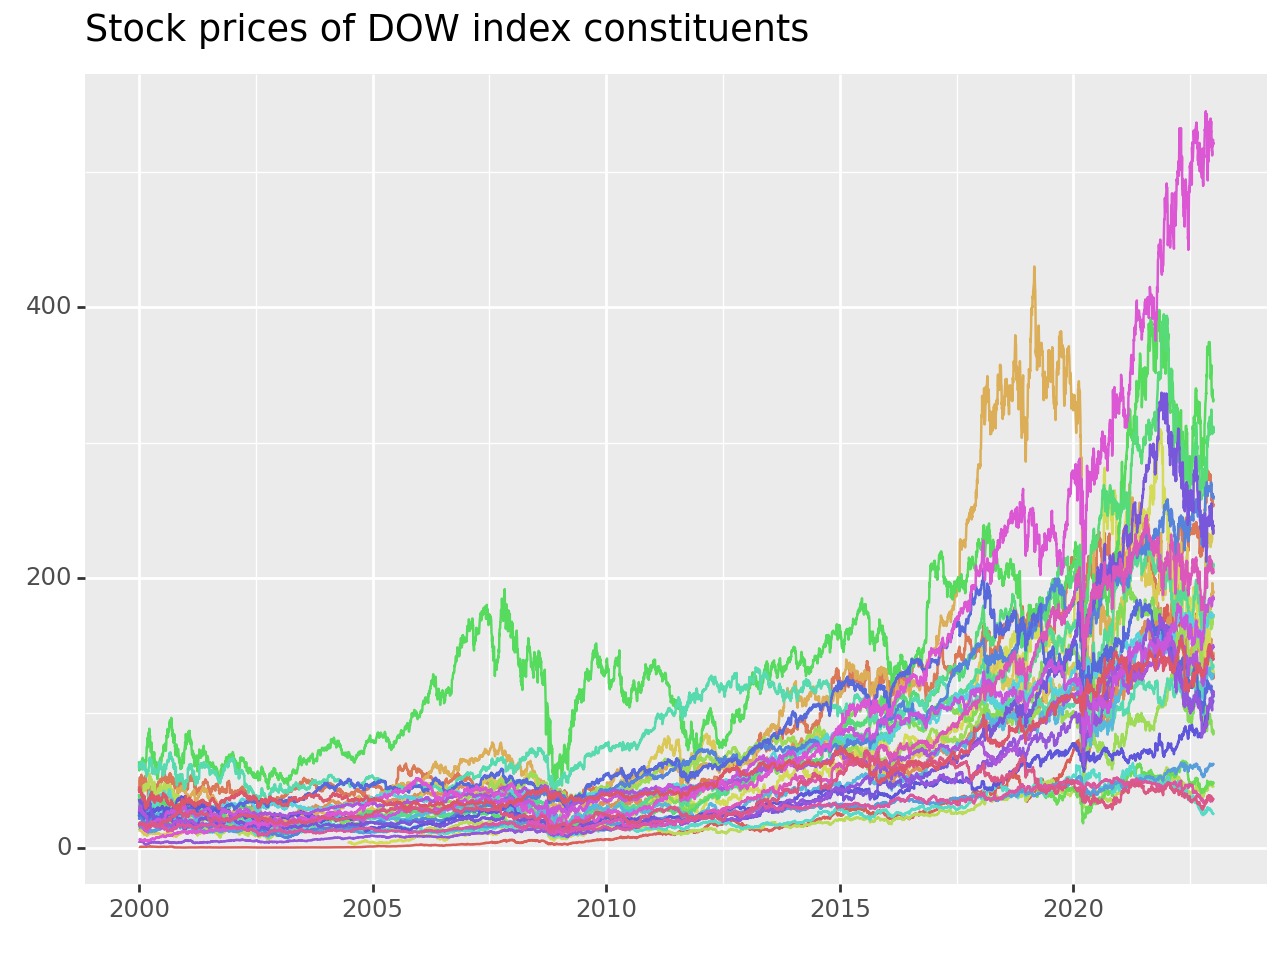

In [13]:
url = ("https://www.ssga.com/us/en/institutional/etfs/library-content/"
       "products/fund-data/etfs/us/holdings-daily-us-en-dia.xlsx")

symbols = (pd.read_excel(url, skiprows=4, nrows=30)
  .get("Ticker")
  .tolist()
)

index_prices = (yf.download(tickers=symbols, 
                            start="2000-01-01",
                            end="2022-12-31",
                            progress=False)
  .melt(ignore_index=False, 
        var_name=["variable", "symbol"])
  .reset_index()
  .pivot(index=["Date", "symbol"], 
         columns="variable", 
         values="value")
  .reset_index()
  .rename(columns = {"Date": "date", 
                     "Open": "open", 
                     "High": "high", 
                     "Low": "low",
                     "Close": "close", 
                     "Adj Close": "adjusted", 
                     "Volume": "volume"
                    })
)

index_prices_figure = (
  ggplot(index_prices, 
         aes(y="adjusted", x="date", color="symbol")) +
 geom_line() +
 labs(x="", y="", color="",
      title="Stock prices of DOW index constituents") +
 theme(legend_position="none") +
 scale_x_datetime(breaks=date_breaks("5 years"), 
                  labels=date_format("%Y")) 
)
index_prices_figure.draw()

In [14]:
all_returns = (index_prices
  .assign(ret = lambda x: x.groupby("symbol")["adjusted"].pct_change())
  .get(["symbol", "date", "ret"])
  .dropna(subset="ret")
)

(all_returns
  .groupby("symbol")["ret"]
  .describe()
  .round(3)
)

/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_2305/3462790525.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,5786.0,0.001,0.025,-0.519,-0.010,0.001,0.013,0.139
AMGN,5786.0,0.000,0.020,-0.134,-0.009,0.000,0.009,0.151
AXP,5786.0,0.001,0.023,-0.176,-0.009,0.000,0.010,0.219
BA,5786.0,0.001,0.022,-0.238,-0.010,0.001,0.011,0.243
CAT,5786.0,0.001,0.020,-0.145,-0.010,0.001,0.011,0.147
CRM,4664.0,0.001,0.027,-0.271,-0.012,0.000,0.014,0.260
CSCO,5786.0,0.000,0.024,-0.162,-0.009,0.000,0.010,0.244
CVX,5786.0,0.001,0.018,-0.221,-0.008,0.001,0.009,0.227
DIS,5786.0,0.000,0.019,-0.184,-0.009,0.000,0.009,0.160


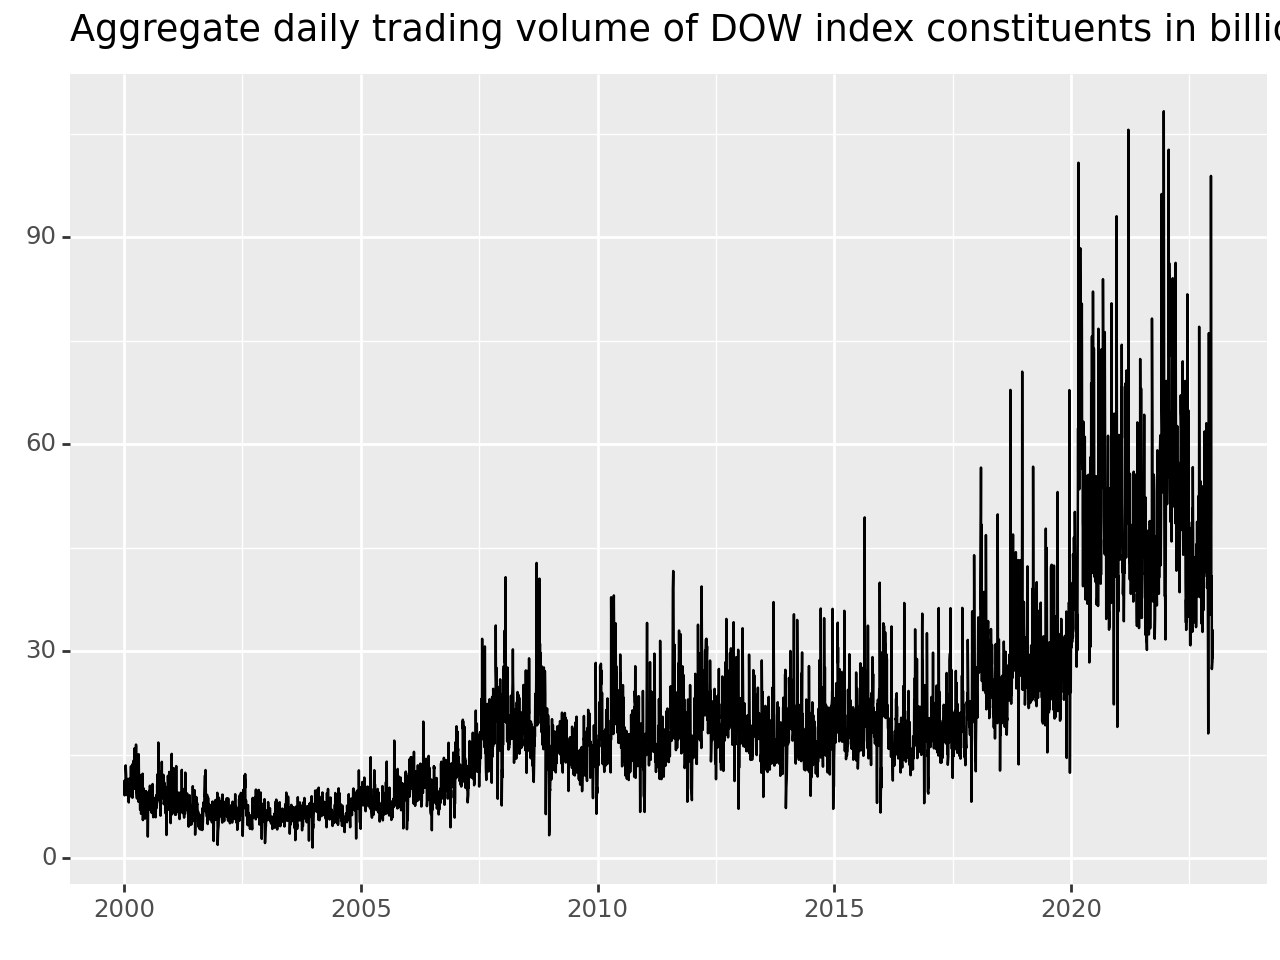

In [15]:
trading_volume = (index_prices
  .assign(trading_volume = lambda x: (x["volume"] * x["adjusted"]) / 1e9)
  .groupby("date")["trading_volume"]
  .sum()
  .reset_index()
  .assign(trading_volume_lag = lambda x: x["trading_volume"].shift())
)

trading_volume_figure = (
  ggplot(trading_volume, 
          aes(x="date", y="trading_volume")) +
  geom_line() +
  labs(x="", y="",
       title="Aggregate daily trading volume of DOW index constituents in billion USD") +
  scale_x_datetime(breaks=date_breaks("5 years"), 
                  labels=date_format("%Y"))
)
trading_volume_figure.draw()

/Users/yunbo/anaconda3/envs/quant/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


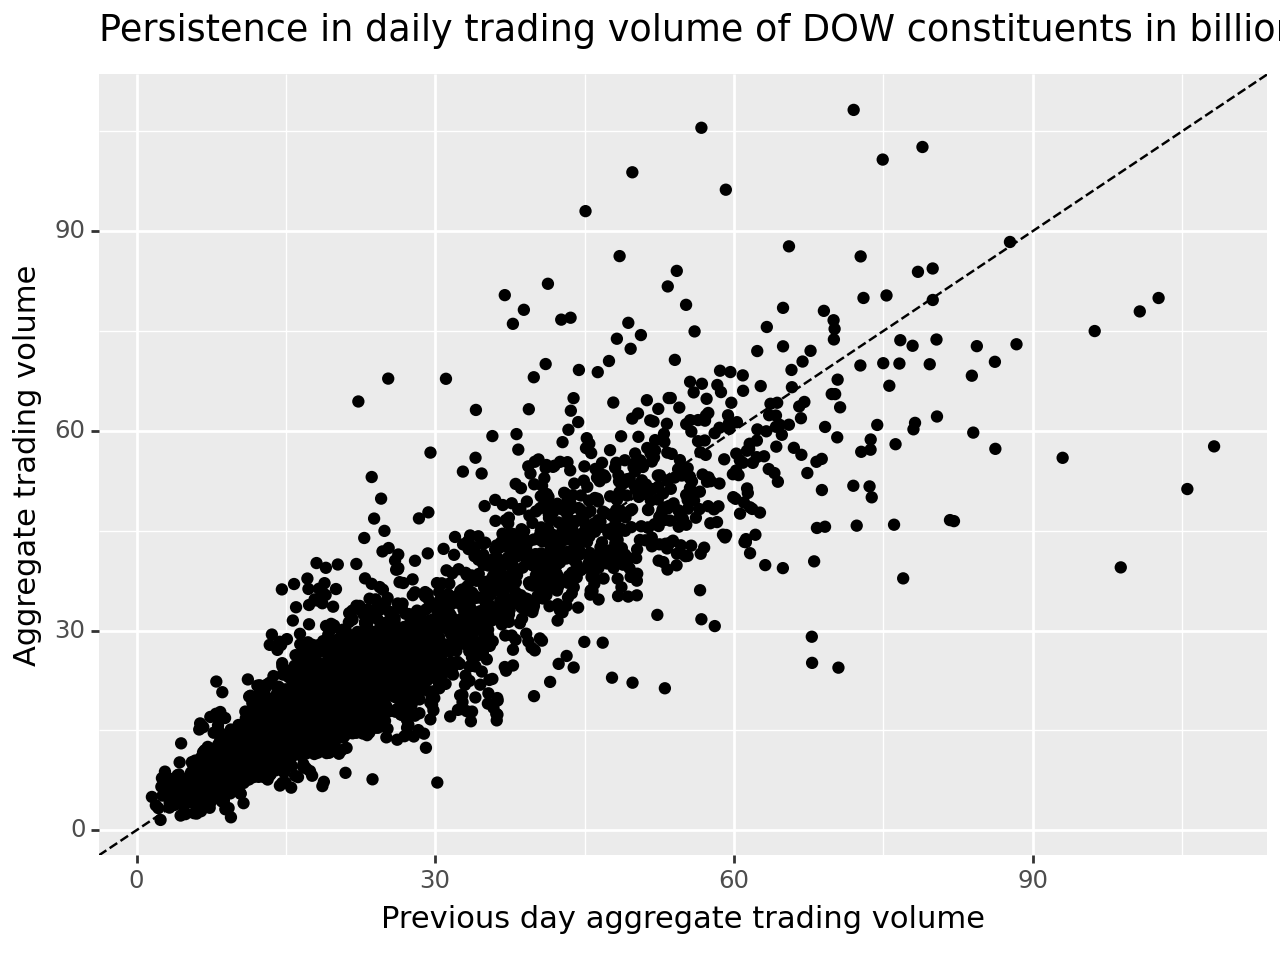

In [16]:
trading_volume_figure = (
  ggplot(trading_volume, 
         aes(x="trading_volume_lag", y="trading_volume")) +
  geom_point() +
  geom_abline(aes(intercept=0, slope=1), linetype="dashed") +
  labs(x="Previous day aggregate trading volume",
       y="Aggregate trading volume",
       title="Persistence in daily trading volume of DOW constituents in billion USD")
)
trading_volume_figure.draw()

# MPT

In [17]:
prices = (index_prices
  .groupby("symbol")
  .apply(lambda x: x.assign(counts = x["adjusted"].dropna().count()))
  .reset_index(drop=True)
  .query("counts == counts.max()")
)

returns_matrix = (prices
  .pivot(columns="symbol", 
         values="adjusted", 
         index="date")
  .resample("m")
  .last()
  .pct_change()
  .dropna()
)
mu = np.array(returns_matrix.mean()).T
sigma = np.array(returns_matrix.cov())

N = returns_matrix.shape[1]
iota = np.ones(N)
sigma_inv = np.linalg.inv(sigma) 

mvp_weights = sigma_inv @ iota
mvp_weights /= mvp_weights.sum()
mvp_return = (mu.T @ mvp_weights)
mvp_volatility = np.sqrt(mvp_weights.T @ sigma @ mvp_weights)
mvp_moments = pd.DataFrame([mvp_return, mvp_volatility],
                          index=["average_ret", "volatility"]).T
mvp_moments.round(3)

benchmark_multiple = 3
mu_bar = benchmark_multiple * mvp_return
C = iota.T @ sigma_inv @ iota
D = iota.T @ sigma_inv @ mu
E = mu.T @ sigma_inv @ mu
lambda_tilde = 2 * (mu_bar - D / C) / (E - D ** 2 / C)

efp_weights = (mvp_weights + lambda_tilde / 2 *
               (sigma_inv @ mu - D * mvp_weights))

# The Efficient Frontier

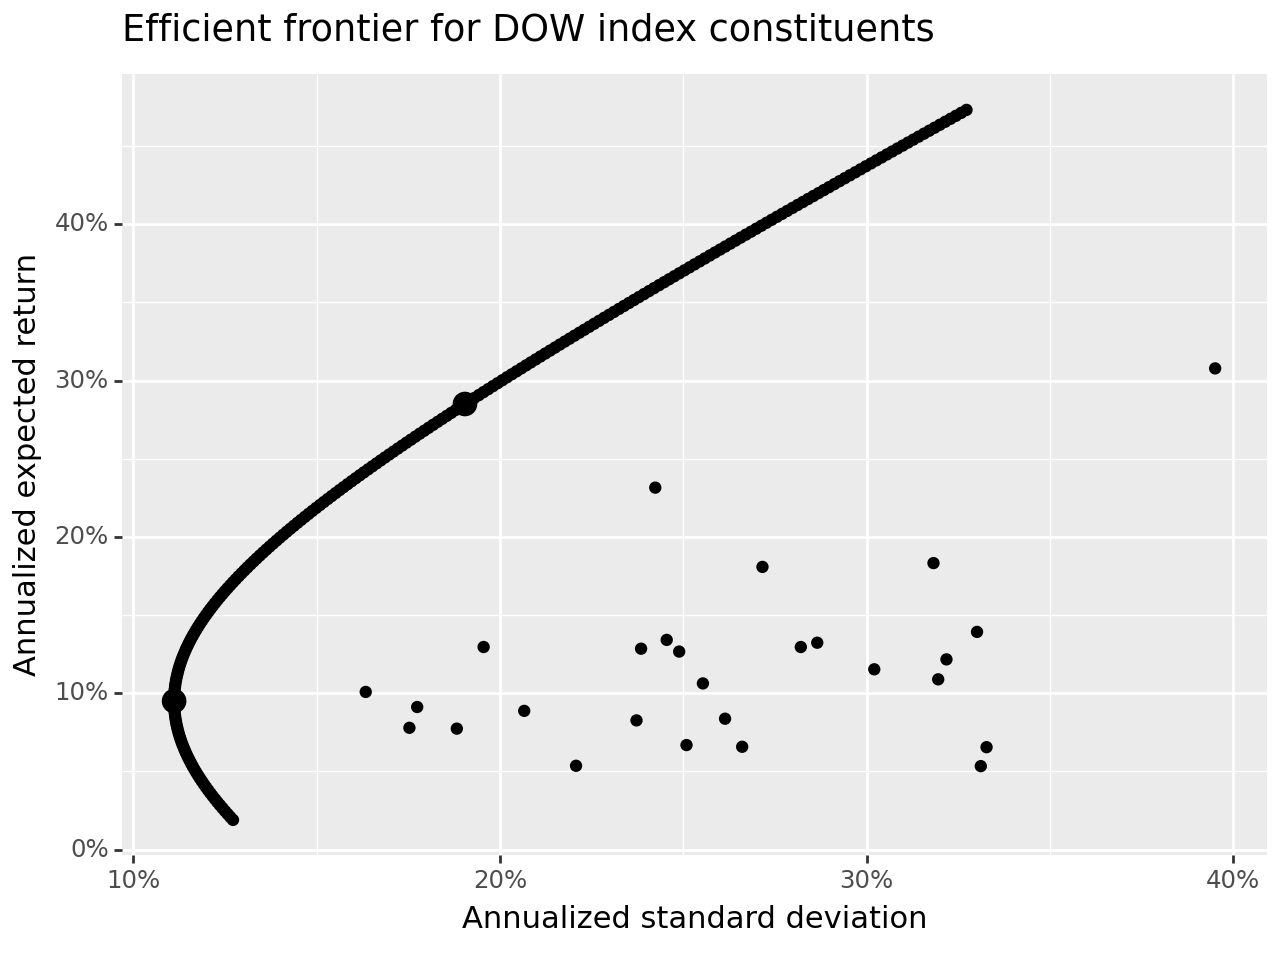

In [18]:
length_year = 12
a = np.arange(-0.4, 2.0, 0.01)
res = pd.DataFrame(columns=["mu", "sd"], index=a).astype(float)

for i in a:
    w = (1 - i) * mvp_weights + i * efp_weights
    res.loc[i, "mu"] = (w.T @ mu) * length_year
    res.loc[i, "sd"] = np.sqrt(w.T @ sigma @ w) * np.sqrt(length_year)

mvp_return = (mu.T @ mvp_weights) * length_year
mvp_volatility = np.sqrt(mvp_weights.T @ sigma @ mvp_weights) * np.sqrt(length_year)
efp_return = mu_bar * length_year
efp_volatility = np.sqrt(efp_weights.T @ sigma @ efp_weights) * np.sqrt(length_year)

res_figure = (
  ggplot(res, aes(x="sd", y="mu")) +
  geom_point() +
  geom_point(
    pd.DataFrame({"mu": [mvp_return, efp_return],
                  "sd": [mvp_volatility, efp_volatility]}),
    size=4
  ) +
  geom_point(
    pd.DataFrame({"mu": mu * length_year,
                  "sd": np.sqrt(np.diag(sigma)) * np.sqrt(length_year)})
  ) +
  labs(x="Annualized standard deviation",
       y="Annualized expected return",
       title="Efficient frontier for DOW index constituents") +
  scale_x_continuous(labels=percent_format()) +
  scale_y_continuous(labels=percent_format())
)
res_figure.draw()